In [43]:
import numpy as np
from keras.applications import vgg16
from keras.preprocessing import image
from keras.activations import relu, softmax
import keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt

In [44]:
# load the model
pretrained_model = vgg16.VGG16(weights='imagenet', include_top=True)
myGraph = tf.compat.v1.get_default_graph()

In [45]:
# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
    return decode_predictions(probs, top=1)[0][0]

(-0.5, 223.5, 223.5, -0.5)

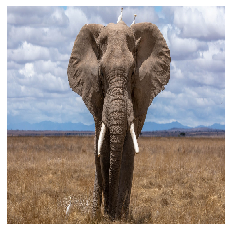

In [46]:
img_path = 'elephant.jpg'
img = image.load_img(img_path, target_size=(224,224))


plt.imshow(img)
plt.grid('off')
plt.axis('off')

In [47]:
# Inverse of the preprocessing and plot the image
def plot_img(x):
    """
    x is a BGR image with shape (? ,224, 224, 3) 
    """
    t = np.zeros_like(x[0])
    t[:,:,0] = x[0][:,:,2]
    t[:,:,1] = x[0][:,:,1]
    t[:,:,2] = x[0][:,:,0]  
    plt.imshow(np.clip((t+[123.68, 116.779, 103.939]), 0, 255)/255)
    plt.grid('off')
    plt.axis('off')
    plt.show()

In [48]:
sess = tf.compat.v1.keras.backend.get_session()

In [52]:
# Create a batch and preprocess the image
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = vgg16.preprocess_input(x)

# Get the initial predictions
preds = pretrained_model.predict(x)
initial_class = np.argmax(preds)
print('Predicted:', vgg16.decode_predictions(preds, top=3)[0])

# with myGraph.as_default():

#     # Get current session (assuming tf backend)
#     sess = tf.compat.v1.Session(graph=myGraph)
    # Initialize adversarial example with input image
x_adv = x
# Added noise
x_noise = np.zeros_like(x)


# Set variables
epochs = 400
epsilon = 0.01
prev_probs = []


for i in range(epochs):

    # One hot encode the initial class
    target = K.one_hot(initial_class, 1000)

    # Get the loss and gradient of the loss wrt the inputs
    loss = K.categorical_crossentropy(target, pretrained_model.output)
    grads = K.gradients(loss, pretrained_model.input)

    # Get the sign of the gradient
    delta = K.sign(grads[0])
    x_noise = x_noise + delta

    # Perturb the image
    x_adv = x_adv + epsilon*delta
    print(x_adv)
#     mySession = tf.Session(graph=myGraph)
#     x_adv = mySession.run(x_adv, feed_dict={pretrained_model.input.experimental_ref():x})

    # Get the new image and predictions
    #x_adv = x_adv.eval(session=sess, feed_dict={pretrained_model.input.experimental_ref():x})
    x_adv = sess.run(x_adv)
    preds = pretrained_model.predict(x_adv)

    # Store the probability of the target class
    prev_probs.append(preds[0][initial_class])

    if i%20==0:
        print(i, preds[0][initial_class], vgg16.decode_predictions(preds, top=3)[0])

plot_img(x_adv)
plot_img(x_adv-x)

Predicted: [('n01871265', 'tusker', 0.61565596), ('n02504458', 'African_elephant', 0.29189894), ('n02504013', 'Indian_elephant', 0.082277045)]
Tensor("add_25:0", shape=(None, 224, 224, 3), dtype=float32)


ValueError: Fetch argument <tf.Tensor 'add_25:0' shape=(None, 224, 224, 3) dtype=float32> cannot be interpreted as a Tensor. (Tensor Tensor("add_25:0", shape=(None, 224, 224, 3), dtype=float32) is not an element of this graph.)